# Proyecto de Clasificación de Enfermedades en Hojas de Manzano

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


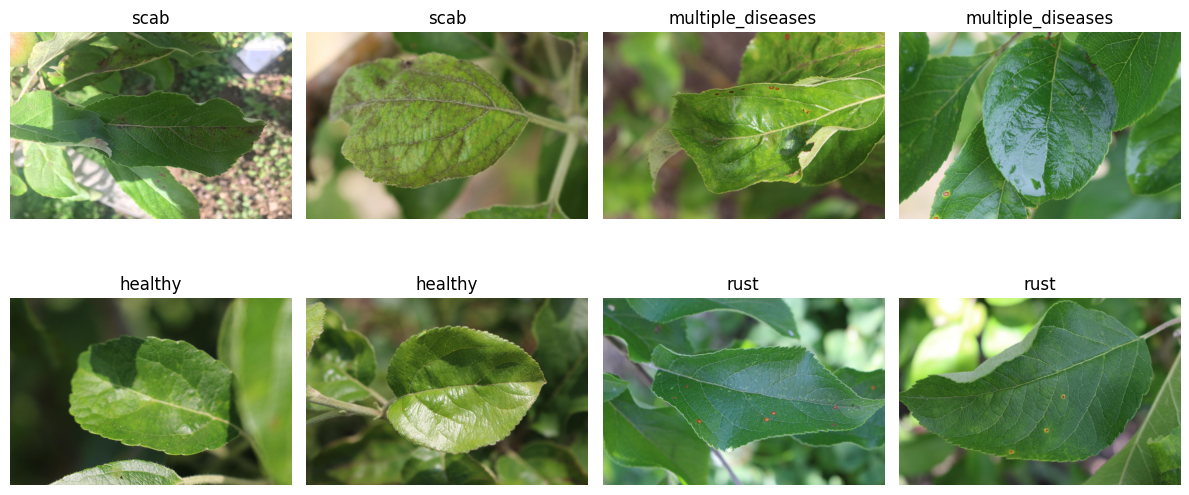

In [2]:
#importando librerias
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Cargar CSV
df = pd.read_csv(
    "/content/drive/MyDrive/plant-pathology-2020-fgvc7/train.csv")

# Crear columna de etiquetas
df["label"] = df[
    ["healthy","multiple_diseases","rust","scab"]].idxmax(axis=1)
df['image'] =df['image_id'].apply(lambda x:f"/content/drive/MyDrive/plant-pathology-2020-fgvc7/images/{x}.jpg")

classes = df['label'].unique()
plt.figure(figsize=(12, 6))
i = 1
for label in classes:
    sample = df[df['label'] == label].sample(2)
    for row in sample.itertuples():
        img = mpimg.imread(row.image)
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()




In [3]:
# División manual: 60% train, 10% val, 30% test ---
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)

print(f"Train: {len(train_df)} | Test: {len(test_df)}")

Train: 1274 | Test: 547


In [4]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label,image
1670,Train_1670,1,0,0,0,healthy,/content/drive/MyDrive/plant-pathology-2020-fg...
440,Train_440,0,0,1,0,rust,/content/drive/MyDrive/plant-pathology-2020-fg...
579,Train_579,1,0,0,0,healthy,/content/drive/MyDrive/plant-pathology-2020-fg...
822,Train_822,0,0,1,0,rust,/content/drive/MyDrive/plant-pathology-2020-fg...
1595,Train_1595,0,0,1,0,rust,/content/drive/MyDrive/plant-pathology-2020-fg...


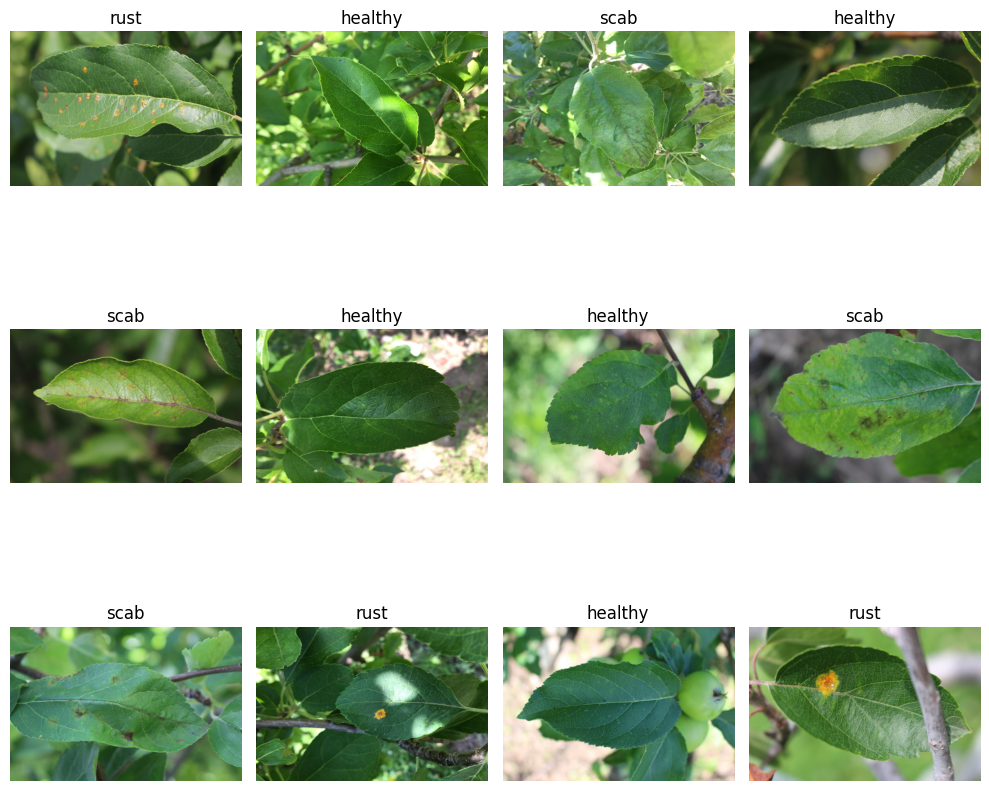

In [5]:

sample_df = df.sample(12)

# Plotting
plt.figure(figsize=(10, 10))
for i, row in enumerate(sample_df.itertuples()):
    img = mpimg.imread(row.image)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# =========================
# 1) Generadores desde DataFrames (train/val/test)
# =========================
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


ih, iw = 224, 224
batch_size = 32
seed = 42


datagen_train = ImageDataGenerator(validation_split=0.143,
                             rescale=1./255,
                             horizontal_flip = True,
                             rotation_range = 20,
                             zoom_range=0.2)
datagen_test = ImageDataGenerator(rescale=1./255,
                             horizontal_flip = True,
                             rotation_range = 20,
                             zoom_range=0.2)

train_gen = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col="image",
    y_col="label",
    target_size=(ih, iw),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

val_gen = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col="image",
    y_col="label",
    target_size=(ih, iw),
    class_mode="categorical",
    subset="validation",
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

int_test_gen = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="image",
    y_col="label",
    target_size=(ih, iw),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)


class_indices = train_gen.class_indices
idx2class = {v:k for k,v in class_indices.items()}
class_names_in_model_order = [idx2class[i] for i in range(len(idx2class))]
print("Orden de clases en la salida del modelo:", class_names_in_model_order)


Found 1274 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Found 547 validated image filenames belonging to 4 classes.
Orden de clases en la salida del modelo: ['healthy', 'multiple_diseases', 'rust', 'scab']


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=3e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])



cbs = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss"),
]

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# =========================
# 3) Entrenamiento
# =========================
epochs = 20
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=cbs
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.4297 - loss: 1.2806 - val_accuracy: 0.7473 - val_loss: 0.7055
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 991ms/step - accuracy: 0.7225 - loss: 0.7666 - val_accuracy: 0.7692 - val_loss: 0.6063
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 982ms/step - accuracy: 0.7615 - loss: 0.6683 - val_accuracy: 0.8077 - val_loss: 0.5651
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 990ms/step - accuracy: 0.8081 - loss: 0.5650 - val_accuracy: 0.8407 - val_loss: 0.4852
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 988ms/step - accuracy: 0.7993 - loss: 0.5524 - val_accuracy: 0.8297 - val_loss: 0.4598
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 984ms/step - accuracy: 0.8107 - loss: 0.5291 - val_accuracy: 0.8407 - val_loss: 0.4017
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 964ms/step - accuracy: 0.7987 - loss: 0.5308 - val_accuracy: 0.8462 - val_loss: 0.3929
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 963ms/step - accuracy: 0.8159 - loss: 0.5045 - val_accurac

In [12]:
loss_v, acc_v = model.evaluate(int_test_gen, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 232s 14s/step - accuracy: 0.8126 - loss: 0.4886


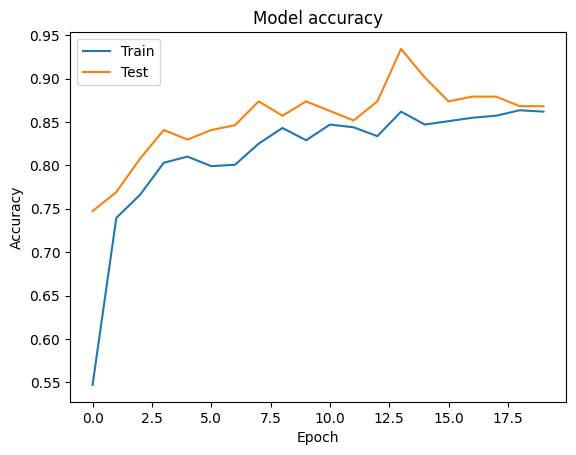

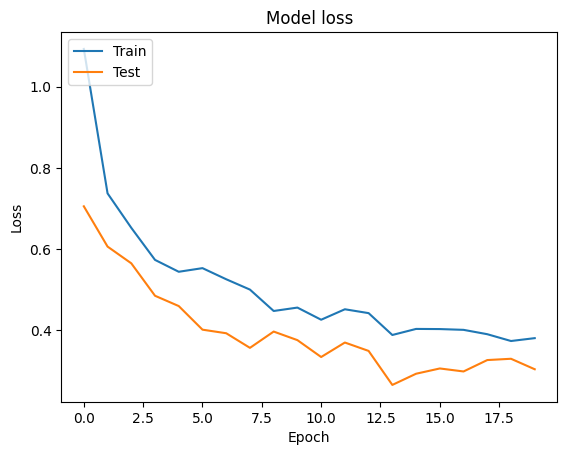

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 764ms/step


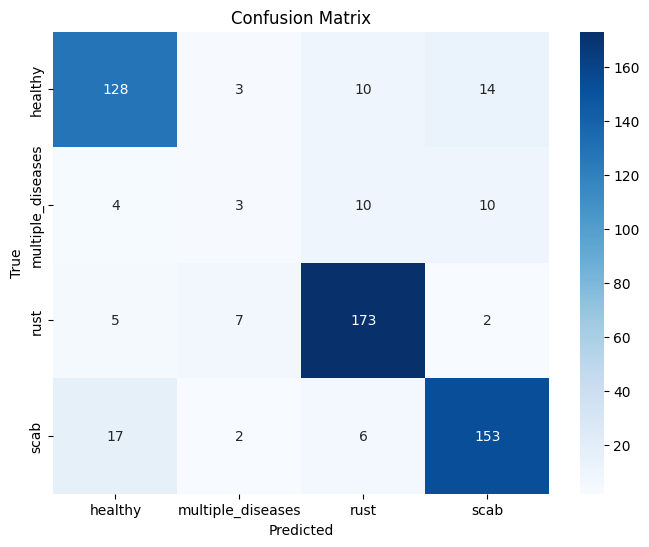

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = int_test_gen.classes
y_pred = model.predict(int_test_gen)
y_pred_classes = y_pred.argmax(axis=1)

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()